In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/features/features.csv


In [2]:
import sklearn as sk
from pathlib import Path

input_dir = Path('/kaggle/input/features')
matrix = pd.read_csv(input_dir / 'features.csv')

features = list(set(matrix.columns) - set(['TARGET', 'SK_ID_CURR']))

X = matrix.copy()[features]
y = matrix.copy().TARGET

### Double check for NAs

In [3]:
X.isnull().sum() #check for NAs

FLAG_EMP_PHONE                0
CODE_GENDER                   0
NAME_INCOME_TYPE              0
FLAG_OWN_REALTY               0
PREPAID_FREQ                  0
AVG_LATE_PAYMENT              0
QUICK_RATIO                   0
NAME_HOUSING_TYPE             0
FLAG_CONT_MOBILE              0
WEIGHTED_AVR_INTEREST_RATE    0
REG_CITY_NOT_LIVE_CITY        0
LIVE_CITY_NOT_WORK_CITY       0
REG_CITY_NOT_WORK_CITY        0
NAME_EDUCATION_TYPE           0
MEAN_DPD                      0
dtype: int64

In [4]:
X.dtypes

FLAG_EMP_PHONE                  int64
CODE_GENDER                    object
NAME_INCOME_TYPE               object
FLAG_OWN_REALTY                object
PREPAID_FREQ                  float64
AVG_LATE_PAYMENT              float64
QUICK_RATIO                   float64
NAME_HOUSING_TYPE              object
FLAG_CONT_MOBILE                int64
WEIGHTED_AVR_INTEREST_RATE    float64
REG_CITY_NOT_LIVE_CITY          int64
LIVE_CITY_NOT_WORK_CITY         int64
REG_CITY_NOT_WORK_CITY          int64
NAME_EDUCATION_TYPE            object
MEAN_DPD                      float64
dtype: object

### Converting Strings to Numeric Types
1. Use 1 hot encoding.

In [5]:
print(X.CODE_GENDER.unique())
print(X.NAME_INCOME_TYPE.unique())
print(X.NAME_HOUSING_TYPE.unique())
print(X.FLAG_OWN_REALTY.unique())
print(X.NAME_EDUCATION_TYPE.unique())

['F' 'M']
['Commercial associate' 'Pensioner' 'Working' 'State servant'
 'Maternity leave' 'Student' 'Unemployed']
['House / apartment' 'Municipal apartment' 'With parents'
 'Office apartment' 'Rented apartment' 'Co-op apartment']
['N' 'Y']
['Secondary / secondary special' 'Higher education' 'Lower secondary'
 'Academic degree' 'Incomplete higher']


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_cols = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 
                 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']

transformer_one_hot = (OneHotEncoder(drop=None), categorical_cols)

transformer = make_column_transformer(
               transformer_one_hot, remainder='passthrough'
            )

encoded = transformer \
            .fit_transform(X)

encoded_df = pd.DataFrame(encoded, \
                          columns=transformer.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Fitting Lasso Logistic Regression
1. Do a train-test split.
2. Fit using L1 Logistic Regression. Hence, require standardisation.
2. Check accuracy and confusion matrix.
3. Do validation to estimate generalisation error.
4. Also use validation to determine optimal hyper-parameters.

#### Logistic Regression Trial 1

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardised_df = scaler.fit_transform(encoded_df)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( \
    standardised_df, y, test_size=0.33, stratify=y, random_state=42)

In [51]:
from sklearn.linear_model import LogisticRegression

def init_log_reg(params: dict):
    penalty = params['PENALTY']
    class_weight = params['CLASS_WEIGHT']
    solver = params['SOLVER']
    multi_class = params['MULTI_CLASS']
    C = params['C']
    max_iter = params['MAX_ITER']
    
    return LogisticRegression(
        penalty=penalty, class_weight=class_weight, solver=solver, 
        multi_class=multi_class)

params = {'PENALTY': 'l1', 'CLASS_WEIGHT': {1: 3, 0:2}, 
          'SOLVER': 'saga', 'MULTI_CLASS': 'ovr', 'C': 0.01, 'MAX_ITER': 100000}

log_reg = init_log_reg(params).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [52]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred, y_test))

0.9180030018168892


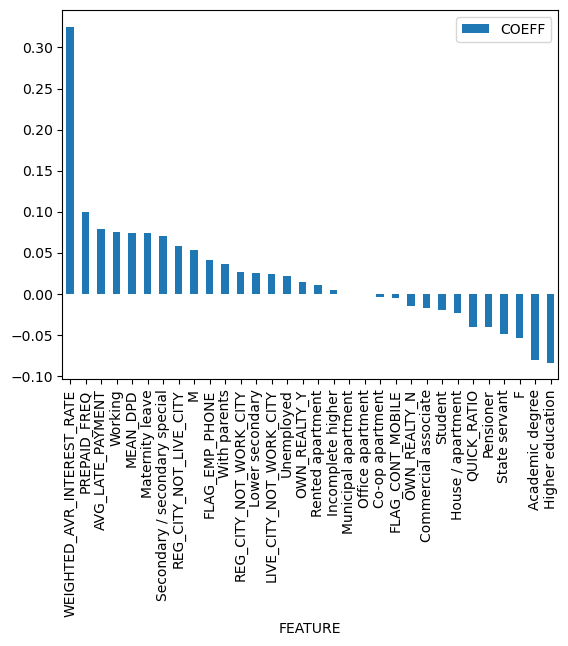

In [53]:
def plot_feature_impt(coeffs, features):
    coeff_dict = {'COEFF': [], 'FEATURE': []}
    
    for ith_coeff, ith_feature in zip(coeffs, features):
        if 'onehotencoder' in ith_feature:
            ith_feature = ith_feature.split('_')[-1]
            if ith_feature in ['N', 'Y']:
                ith_feature = f'OWN_REALTY_{ith_feature}'
        
        coeff_dict['COEFF'].append(ith_coeff)
        coeff_dict['FEATURE'].append(ith_feature)
    
    df = pd.DataFrame(coeff_dict).sort_values(by='COEFF', ascending=False)
    df.plot.bar(x='FEATURE', y='COEFF')
    
features = encoded_df.columns
plot_feature_impt(log_reg.coef_[0], features)

### Logistic Regression: ROC and Generalisation Error.
TODO:
1. Read about coefficients of Log Reg and Log Reg.
2. Read about performing ROC and LogRegCV.